In [301]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [307]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten, Concatenate, Input, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd

# 데이터 로드 및 전처리

In [308]:

news_data = pd.read_csv('/content/drive/My Drive/ITchosun_content.csv')

news_data=news_data.rename(columns={"small_category":'category'})
news_data=news_data.dropna(axis=0)
news_data.reset_index(drop=True, inplace=True)
news_data

,link,title,date,content,tag,big_category,category
0,http://it.chosun.com/site/data/html_dir/2020/0...,"LG, AI로 차세대 화학소재 개발 나선다",2020.09.13,"[<div class=""par"">LG가 친환경 촉매, 차세대 소재 등 화학소재 개발...","lg사이언스파크,화학소재,인공지능,ai,a3md,토탈",기술,과학·기술
1,http://it.chosun.com/site/data/html_dir/2020/0...,"현대차·인천시, 국토부 ‘스마트시티 챌린지 사업’ 협약 맺어",2020.09.13,"[<div class=""par"">현대자동차가 인공지능 기반 통합 모빌리티 서비스 고...","자동차,국산차,현대자동차,컨소시엄,스마트챌린지",자동차,일반
2,http://it.chosun.com/site/data/html_dir/2020/0...,"[차주경의 테크&영화] 그러게 고독이 무섭다니까, 패신저스(Passengers, 2...",2020.09.13,"[<div class=""par""><span style=""color:#0000ff;""...","영화,테크,기술,ict,인공지능,ai,가상현실,vr,로봇,칩,인공두뇌,증강현실,바이...",게임·라이프,미디어·엔터테인먼트
3,http://it.chosun.com/site/data/html_dir/2020/0...,"[주간 테크 뉴스] 넥슨, 부당한 방법으로 단숨에 던파 1위 등극 의혹",2020.09.12,"[<div class=""par"">2020년 9월 7일부터 9월 11일까지 한 주간 ...","IT조선, itchosun, IT조선, 일반",기업,일반
4,http://it.chosun.com/site/data/html_dir/2020/0...,"메가존 클라우드, AI 유니콘 '그래프코어'와 총판 계약 체결",2020.09.11,"[<div class=""par"">클라우드 관리 기업<span style=""font-...","메가존클라우드,메가존,그래프코어,이주완,자연어처리,컴퓨터비전,ai",기업,컴퓨팅·IT서비스
...,...,...,...,...,...,...,...
1966,http://it.chosun.com/site/data/html_dir/2019/0...,"'눈 가리고 달리는' 중국 기술개발, 개인정보·인권 무시에 사회 감시까지",2019.09.05,"[<div class=""par"">중국이 미국 기술 리더십에 도전하는 과정에서 끊임없...","중국,자오,딥페이크,감시,통제,위구르족,아이폰해킹,멀웨어",기술,로봇·드론·VR
1967,http://it.chosun.com/site/data/html_dir/2019/0...,"코닥은 ‘폭망’ 인스타는 '대박'…“창의적인건 실패 가능성 높지만 끝까지 밀어부쳐야""",2019.09.05,"[<div class=""par"">코닥은 디지털 카메라 시장 선구자다. 누구도 코닥의...","실패박물관,사무엘웨스트,스타트업,혁신",기업,중기·벤처
1968,http://it.chosun.com/site/data/html_dir/2019/0...,"KT, 관리시스템 ‘아타카마’로 글로벌 시장 도전",2019.09.04,"[<div class=""par"">KT가 50억원을 투자해 빅데이터 기반 차세대 외부...","아타카마,차세대osp관리시스템,kt,5g,사파이어,아현화재",기업,방송·통신
1969,http://it.chosun.com/site/data/html_dir/2019/0...,"인텔, IFA서 '10세대' 노트북 대거 공개…차세대 노트북 비전 제시한다",2019.09.04,"[<div class=""par"">인텔이 독일 베를린에서 열리는 IFA 2019에서 ...","인텔,ifa2019,10세대프로세서,아테나프로젝트,오픈랩,노트북,2in1,pc혁신",기업,PC·가전·모바일


In [309]:
news_data['big_category'].unique()

array(['기술', '자동차', '게임·라이프', '기업', '칼럼·해설', '사람', '전체 기사', '뉴스'],
      dtype=object)


================================================

<기술>
- 공통 --> 일반
- 기술 --> 과학·기술 , 보안 , 로봇·드론·VR

=================================================

<게임·라이프>
- 문화/예술 --> 미디어·엔터테인먼트, 게임·인터넷
- 사회 --> 유통·쇼핑, 키덜트·키즈, 일반

=======================================================

<기업>
- 일반, 중기·벤처, 산업일반, 중공업 제거

- 공통 --> 컴퓨팅·IT서비스, 방송·통신, 외신
- 경제 --> 금융·핀테크
- 건강 --> 헬스케어·바이오
- 기술 --> PC·가전·모바일, 반도체·디스플레이


In [310]:
tech=news_data[news_data['big_category'] == '기술'].index ################# 기술
news_data.iloc[tech].category.unique()  # '과학·기술', '일반', '로봇·드론·VR', '보안'

game_life=news_data[news_data['big_category'] == '게임·라이프'].index
news_data.iloc[game_life].category.unique() #'미디어·엔터테인먼트', '게임·인터넷', '유통·쇼핑', '일반', '키덜트·키즈'

company=news_data[news_data['big_category'] == '기업'].index 
news_data.iloc[company].category.unique() #'일반', '컴퓨팅·IT서비스', 'PC·가전·모바일', '금융·핀테크', '중기·벤처', '반도체·디스플레이', '헬스케어·바이오', '외신', '방송·통신', '산업일반', '중공업'


array(['일반', '컴퓨팅·IT서비스', 'PC·가전·모바일', '금융·핀테크', '중기·벤처', '반도체·디스플레이',
       '헬스케어·바이오', '외신', '방송·통신', '산업일반', '중공업'], dtype=object)


카테고리 삭제

In [311]:
news_data['category'].value_counts()

drop1=news_data[news_data['big_category'] == '자동차'].index
news_data=news_data.drop(drop1)
drop2=news_data[news_data['big_category'] == '칼럼·해설'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '사람'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '전체 기사'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '뉴스'].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='일반')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='중기·벤처')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='산업일반')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='중공업')].index
news_data=news_data.drop(drop2)


news_data.reset_index(drop=True, inplace=True)

팀메이트에 맞는 카테고리로 변환 --> 교육이 없음ㅠㅠ

In [312]:
import numpy as np

news_data['team_category'] = np.nan
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='과학·기술')].index]='기술'

news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='보안')].index] = '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='로봇·드론·VR')].index] = '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='일반')].index]= '공통'

news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='미디어·엔터테인먼트')].index]= '문화/예술'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='게임·인터넷')].index] = '문화/예술'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='유통·쇼핑')].index] = '사회'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='키덜트·키즈')].index] = '사회'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='일반')].index] = '사회'

news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='컴퓨팅·IT서비스')].index] = '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='방송·통신')].index] = '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='외신')].index]= '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='금융·핀테크')].index] = '경제'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='헬스케어·바이오')].index]= '건강'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='PC·가전·모바일')].index]= '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='반도체·디스플레이')].index] = '기술'



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [313]:
news_data.isna().sum()
news_data['team_category']

0          기술
1       문화/예술
2          공통
3          기술
4          기술
        ...  
1399       기술
1400       기술
1401       공통
1402       기술
1403       기술
Name: team_category, Length: 1404, dtype: object

In [314]:
# 카테고리 정수 인코딩

category_list = pd.factorize(news_data['team_category'])[1]
news_data['category'] = pd.factorize(news_data['team_category'])[0]

news_data['category'].unique()
category_list.nunique()

news_data=news_data[['title','content','tag','category']]

In [315]:
news_data['category'].value_counts() # 6개의 카테고리

2    691
0    371
1    158
3     79
4     61
5     44
Name: category, dtype: int64

# 뉴스 제목, 기사 내용, 태그 내용 전처리

In [ ]:
# 뉴스 제목 전처리, 단어 이외의 문자들은 띄어쓰기로 변경
news_data['title'] = news_data['title'].str.replace("[^\w]", " ")

In [317]:
#  기사 내용 전처리, 괄호 단어 뽑기, 괄호 제거, 기호 제거 후 띄어쓰기로 분리 준비

import re
p = re.compile(r'<.+?>') #html 구조 제거
p2 = re.compile(r'\(([^)]+)') # 괄호 뽑기
p3 = re.compile( r'\([^)]*\)') # 괄호 제거

news_data['regex_content'] = ''
news_data['regex_blank'] = ''

for n in range(len(news_data['content'])):
  sub_content= re.sub(p,'',news_data['content'][n]) #html 구조 제거한 기사 문장
  news_data['regex_blank'][n]= p2.findall(news_data['content'][n]) #괄호 단어 뽑은 리스트
  sub_content = re.sub(p3,' ',sub_content) #괄호 제거한 기사 문장
  sub_content = sub_content.replace("[^\w]", " ")
  news_data['regex_content'][n] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·∙!』\\’‘|\(\)\[\]\<\>`\'…》]', ' ', sub_content)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
#태그 전처리

news_data['tag_1'] = ''

for i in range(len(news_data['tag'])) :
  news_data['tag_1'][i]= news_data['tag'][i].replace(',',' ')

  # .replace(',',' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
news_data['regex_content'][0]

' LG가 친환경 촉매  차세대 소재 등 화학소재 개발 분야에서 인공지능 와 로봇 기술을 활용한 혁신을 가속화한다 LG사이언스파크는 11일 캐나다의 토론토대학교와 맥마스터대학교  프랑스 에너지 석유회사  토탈 과 함께  AI 기반 소재 개발 컨소시엄  을 결성해 공동연구를 추진한다고 13일 밝혔다   A3MD는 AI를 활용한 소재 개발 분야에서 글로벌 최고 수준의 학계와 산업계 파트너가 함께 참여하는 AI 연합이다 LG는 창립 멤버로 참여했다  신소재 개발을 위한 AI 선행기술을 확보하는 동시에 소재 분야 AI 석학 등과 함께 공동 연구개발 네트워크 기반을 구축한다 컨소시엄은  친환경 촉매 와  차세대 광학소재  개발이 목표다  다양한 AI 모델링 및 자동화 실험 플랫폼 구축 등을 진행한다 보통 석유화학 공정에서 뽑아내는 에틸렌과 같은 화합물은 공기 중의 이산화탄소로부터도 생산할 수 있다  이때 화학반응을 유도하는 촉매를 머신러닝과 자동화 로봇 시스템을 이용해 설계할 수 있다는 것이다  전기를 빛으로 변환하는  페로브스카이트  같은 차세대 소재도 슈퍼컴퓨터 시뮬레이션과 AI 모델링 등을 통해 개발기간을 앞당기고 발광소재 등으로 활용도를 넓힐 수 있다 기존의 소재 연구는 먼저 신규 소재를 발굴한 뒤  이를 합성하고 물성을 검증하는 과정을 반복해야 해 신소재 개발에 수년 혹은 십수년 시간이 소요될 수 밖에 없었다 AI 기술을 소재 개발에 적용하면 소재 물성에 대한 데이터를 보다 정확하게 파악할 수 있다  반복 실험을 거쳐야 하는 기존 연구방법보다 개발 비용이나 기간을 대폭 줄여 고객사별 맞춤형 소재를 보다 제공할 수 있다 컨소시엄에는 소재 정보학  계산 화학 및 로봇을 이용한 대규모 실험 자동화 분야의 AI 권위자인 토론토대 테드 사전트 와 알란 아스푸루구직   맥마스터대 드류 히긴스  등 교수진이 참여한다  에너지 데이터 분석을 위한 AI 솔루션 개발에 적극적인 토탈도 산업계 파트너로 참여한다 A3MD는 비대면 온라인 화상회의 등을 통해 공동 프로젝트를 진행하면

In [318]:
# 메캅 사용 X -> split으로 대체
########################################## ########################################## ########################################## 
# ######################                     MECAB 설치 https://sosomemo.tistory.com/31                     ###################### 
# ########################################## ########################################## ########################################## 

# !apt-get update
# !apt-get install g++ openjdk-8-jdk
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
news_data['headline']=news_data['title'] +' ' + news_data['tag_1'] + ' ' + news_data['regex_content']
news_data['headline']

# 불용어 제거, 토큰화 진행 --> 띄어쓰기 기준으로 문장 잘라 list에 담기
stopwords = ['','또','함께','수','를','을','등','으로','것','약','가','이','즉','은','될','큰','는','로','및','에','그','곧','기자','chosunbiz','며','우리','com','위해','아니라','고','바','와','과','있다','통해','뒤','해','밖에','대한','보다','하는','위한','등을']

X_token = []
for stc in news_data['headline']:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_token.append(token)


In [ ]:
len(X_token),len(news_data['category'])

(1404, 1404)

# test, trainset / classification fitting

In [ ]:
from sklearn.model_selection import train_test_split

# split하면서 shuffle 적용
X_train, X_test, y_train, y_test = train_test_split(X_token, news_data['category'], test_size=0.2,shuffle=True)

# 카테고리 OnehotVector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(y_train[0]))
print(len(y_test[0]))

# y_train.nunique(), y_test.nunique()

6
6


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 헤드라인 정수인코딩
tokenizer = Tokenizer(20000) # 가장 빈도가 높은 10000개의 단어만 선택하도록 함
tokenizer.fit_on_texts(X_train) #vocabulary 만들기
X_train = tokenizer.texts_to_sequences(X_train) # vocabulary랑 매칭해 인덱스로 나타내기, 리스트 변환
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(len(tokenizer.word_index))

wc = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count <= 2:
        wc += 1

print(wc)

82447
62233


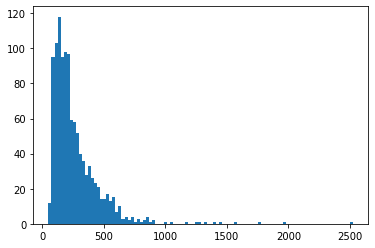

In [ ]:
import matplotlib.pyplot as plt # 500단어

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc, bins=100)
plt.show()

In [ ]:
max_len = 500 # 헤드라인 문장 길이를 보고 맞춰주기 - 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128))
model.add(Dense(6, activation='softmax')) #출력개수 6개의 카테고리

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=100, epochs=15)

#batch_size : 한번의 batch마다 주는 데이터 샘플 사이즈/ 한 번에 모든 데이터를 넣을 수가 없음
#iteration 
# epoch : 전체 데이터 셋에 대해 한 번 학습을 완료한 상태

Epoch 1/15
12/12 [==============================] - 19s 2s/step - loss: 1.7070 - acc: 0.4568 - val_loss: 1.4158 - val_acc: 0.4662
Epoch 2/15
12/12 [==============================] - 18s 2s/step - loss: 1.3278 - acc: 0.4987 - val_loss: 1.3170 - val_acc: 0.4662
Epoch 3/15
12/12 [==============================] - 18s 2s/step - loss: 1.1700 - acc: 0.5013 - val_loss: 1.2447 - val_acc: 0.4662
Epoch 4/15
12/12 [==============================] - 18s 2s/step - loss: 0.8923 - acc: 0.6046 - val_loss: 1.1184 - val_acc: 0.5338
Epoch 5/15
12/12 [==============================] - 18s 2s/step - loss: 0.5890 - acc: 0.7863 - val_loss: 1.7349 - val_acc: 0.5302
Epoch 6/15
12/12 [==============================] - 18s 2s/step - loss: 0.4953 - acc: 0.8210 - val_loss: 1.2037 - val_acc: 0.5196
Epoch 7/15
12/12 [==============================] - 18s 2s/step - loss: 0.3996 - acc: 0.8584 - val_loss: 1.3109 - val_acc: 0.5730
Epoch 8/15
12/12 [==============================] - 18s 2s/step - loss: 0.3138 - acc: 0.87

# AI타임즈 최근 뉴스120개 분류해보기

In [ ]:
test_csv=pd.read_csv('/content/drive/My Drive/times_content.csv')
test_list =pd.read_csv('/content/drive/My Drive/AItimes_list.csv')

times_data= pd.merge(test_csv, test_list,on='link')
times_data = times_data[['tag','content','title']]

In [ ]:
times_data

,tag,content,title
0,"엔비디아,ARM,소프트뱅크,GPU,CPU,반도체",[<p>결국 엔비디아가 ARM을 인수했다. 인수액은 400억달러(약 47조원). 전...,"엔비디아, ARM 인수 '확정'…젠슨 황, ""AI 시대를 위한 결정"""
1,NaN,[<p>광주와 전남지역을 합쳐 하나의 지방자치단체를 만들자는 '광주·전남 행정통합'...,광주·전남 행정 통합 논의 시동 걸었다
2,NaN,"[<p> </p>, <p>1조원의 예산이 투입되는 AI 중심 산업융합 집적단지가 광...",[Monday News] 'AI 중심도시 광주' 이것이 풀어야 할 과제다 ④ 광주 ...
3,"5G,전자파,전자기파,전파,무선통신,이동통신,과기정통부",[<p>국립전파연구원이 전자파에 대한 올바른 정보를 제공한다. 온라인 포럼을 통해 ...,"인체에 유해한 전자파?…국립전파연구원, '팩트체크' 자리 마련"
4,NaN,"[<p>삼성전기가 초소형 파워인덕터를 개발했다. </p>, <p>파워인덕터는 반도체...","삼성전기, 초소형 파워인덕터 개발…엣지 AI 소형화 가속"
...,...,...,...
115,"국립전파연구원,국제전기통신연합,ITU,ITU-T,SG17,양자암호통신,정보보호,국제...",[<p>국제표준기구가 국내 연구진 주도로 제안한 정보보호 분야 표준안 8건을 국제 ...,국내 주도 ICT 보안 표준안 8건 '국제 표준' 채택
116,NaN,[<p>4족 보행 로봇 ‘스폿(Spot)’이 코로나19 최전방에서 고생하는 의료진에...,"로봇견 ‘스폿’, 코로나19 최전방서 의료진 도와 활약할까"
117,"산업통상자원부,인공지능반도체,AI반도체,자율주행차,사물인터넷,IoT,바이오,로봇,미세공정",[<p>정부가 인공지능(AI) 반도체 상용화를 목표로 관련 기술 개발에 착수한다. ...,"산업부, AI 반도체 상용화 위한 기술 개발 추진… 미래차ㆍIoT 등에 적용한다"
118,"한국인공지능학회,인공지능,AI,인공지능대학원,AI대학원,바이오의료,신경과학,컴퓨터비전",[<p>한국인공지능학회(학회장 유창동)는 인공지능(AI) 연구자의 학술 교류 및 최...,"한국인공지능학회, '2020년 하계학술대회' 열어 AI 연구 조망"


In [319]:
# 뉴스 제목 전처리, 단어 이외의 문자들은 띄어쓰기로 변경
times_data['title'] = times_data['title'].str.replace("[^\w]", " ")

# 기사 내용 전처리, 괄호 단어 뽑기, 괄호 제거 후 띄어쓰기
import re
p = re.compile(r'<.+?>') #html 구조 제거
p2 = re.compile(r'\(([^)]+)') # 괄호 뽑기
p3 = re.compile( r'\([^)]*\)') # 괄호 제거

times_data['regex_content'] = ''
times_data['regex_blank'] = ''

for n in range(len(times_data['content'])):
  sub_content= re.sub(p,'',times_data['content'][n]) #html 구조 제거한 기사 문장
  times_data['regex_blank'][n]= p2.findall(times_data['content'][n]) #괄호 단어 뽑은 리스트
  sub_content = re.sub(p3,' ',sub_content) #괄호 제거한 기사 문장
  sub_content = sub_content.replace("[^\w]", " ")
  times_data['regex_content'][n] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·∙!』\\’‘|\(\)\[\]\<\>`\'…》]', ' ', sub_content)

times_data['regex_content']

# 태그 내용 전처리

times_data['tag_1'] = ''
for i in range(len(times_data['tag'])) :
  if times_data['tag'].isnull()[i]: times_data['tag_1'][i] = ""
  else : times_data['tag_1'][i]= times_data['tag'][i].replace(',',' ')

  
times_data['headline']=times_data['title'] +' ' + times_data['tag_1'] + ' ' + times_data['regex_content']
times_data['headline']

0       결국 엔비디아가 ARM을 인수했다  인수액은 400억달러   전날 월스트리트저널 ...
1       광주와 전남지역을 합쳐 하나의 지방자치단체를 만들자는  광주 전남 행정통합 이 본...
2          1조원의 예산이 투입되는 AI 중심 산업융합 집적단지가 광주에 조성되고 있는...
3       국립전파연구원이 전자파에 대한 올바른 정보를 제공한다  온라인 포럼을 통해 5G ...
4       삼성전기가 초소형 파워인덕터를 개발했다    파워인덕터는 반도체에 안정적인 전력을...
                             ...                        
115     국제표준기구가 국내 연구진 주도로 제안한 정보보호 분야 표준안 8건을 국제 표준으...
116     4족 보행 로봇  스폿  이 코로나19 최전방에서 고생하는 의료진에 힘을 보탤 수...
117     정부가 인공지능  반도체 상용화를 목표로 관련 기술 개발에 착수한다  민간 기관과...
118     한국인공지능학회 는 인공지능  연구자의 학술 교류 및 최근 기술 동향을 공유할 목...
119     마스크 착용 여부와 체온을 측정해 코로나19 방역 관리 효율을 높일 수 있는  5...
Name: regex_content, Length: 120, dtype: object

In [ ]:
# 불용어 제거, 토큰화 진행 --> 띄어쓰기 기준으로 문장 잘라 list에 담기

stopwords = ['','함께','하지만','뿐','한','또','수','결국','를','을','등','으로','것','약','가','이','즉','은','될','큰','는','로','및','에','그','곧','기자','chosunbiz','며','우리','com','위해','아니라','고','바','와','과','있다','통해','뒤','해','밖에','대한','보다','하는','위한','등을']

X_token = []
for stc in times_data['headline']:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_token.append(token)

In [ ]:
# token_stc =m.nouns(sentence)
empty = []

for token_stc in X_token :
  encode_stc = tokenizer.texts_to_sequences([token_stc])
  pad_stc = pad_sequences(encode_stc, maxlen=500)
  score = model.predict(pad_stc)
  result_category = category_list[score.argmax()]
  result_prob= score[0, score.argmax()] # 확률값 반환
  empty.append([result_category, result_prob])

In [289]:
result=pd.DataFrame(empty,columns=['category','prob'])
resultttt=pd.concat([times_data,result],axis=1)

resultttt[['title','category','prob']]

,title,category,prob
0,엔비디아 ARM 인수 확정 젠슨 황 AI 시대를 위한 결정,공통,0.989911
1,광주 전남 행정 통합 논의 시동 걸었다,기술,0.993323
2,Monday News AI 중심도시 광주 이것이 풀어야 할 과제다 ④ 광주 ...,기술,0.592432
3,인체에 유해한 전자파 국립전파연구원 팩트체크 자리 마련,공통,0.873029
4,삼성전기 초소형 파워인덕터 개발 엣지 AI 소형화 가속,공통,0.991820
...,...,...,...
115,국내 주도 ICT 보안 표준안 8건 국제 표준 채택,기술,0.949060
116,로봇견 스폿 코로나19 최전방서 의료진 도와 활약할까,공통,0.774538
117,산업부 AI 반도체 상용화 위한 기술 개발 추진 미래차ㆍIoT 등에 적용한다,기술,0.734547
118,한국인공지능학회 2020년 하계학술대회 열어 AI 연구 조망,공통,0.882606


In [290]:
resultttt.category.value_counts()

기술       58
공통       51
문화/예술     7
경제        3
건강        1
Name: category, dtype: int64

In [300]:
resultttt[resultttt.category == '문화/예술'][['tag','headline','category','prob']].sort_values(['prob'],ascending=False)

,tag,headline,category,prob
28,NaN,기획 ①코로나 블루 시대 AI음악이 위로한다 안창욱 지스트 교수 인공지능 이...,문화/예술,0.871107
66,"산업부,교육부,ICT,디지털전환,에듀테크,비대면,언택트,AI,가상현실,AR,증강현실",2020 에듀테크 코리아 9일 온라인 개막 산업부 교육부 ICT 디지털전환 에듀...,문화/예술,0.619562
67,NaN,메디컬아이피 서울성모병원과 3D 해부학 모델 공동 개발 메디컬아이피 가 서...,문화/예술,0.604296
92,"전자피부,인공피부,센서,로봇,RMIT",사람처럼 고통에 반응하는 전자피부 개발 전자피부 인공피부 센서 로봇 RMIT ...,문화/예술,0.430442
52,NaN,난 인간을 전멸시키지 않을 것 가디언지에 칼럼 쓴 GPT3 “생각으로 머...,문화/예술,0.399849
31,"브이리뷰,Vreview,인덴트코퍼레이션,챗봇,영상후기,구매후기동영상,위젯",인덴트코퍼레이션 AI 동영상 리뷰 서비스 3억건 노출 브이리뷰 Vreview 인덴트...,문화/예술,0.272593
99,NaN,전남에서 게임 창업하자 스타트업 지원 행사 눈길 미래 국내 게임 산업을 ...,문화/예술,0.239320
